In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
import os, sys
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [2]:
ds = json.load(open("data/newsqa/combined-newsqa-data-v1.json"))

In [3]:
ds = ds['data']

In [4]:
train = [_ for _ in ds if _['type'] == 'train']
dev = [_ for _ in ds if _['type'] == 'dev']
test = [_ for _ in ds if _['type'] == 'test']

In [5]:
ds[0].keys()

dict_keys(['text', 'type', 'questions', 'storyId'])

In [6]:
print(len(ds[0]['questions']))
print( ds[0]['questions'][0].keys() )
print(ds[0]['type'])

9
dict_keys(['isQuestionBad', 'consensus', 'validatedAnswers', 'answers', 'q', 'isAnswerAbsent'])
train


In [7]:
print(len(ds))

12744


In [8]:
train[0]['questions'][0]['consensus']

{'s': 294, 'e': 297}

In [9]:
print(len(train), len(dev), len(test))

11469 638 637


In [10]:
# qa items
def get_consus_stage_1_questions(ds):
    consensus_qa_items_stage_1 = {'id':[], 'context':[], 'question':[], 'answers':[]}
    consensus_after_validate = {'id':[], 'context':[], 'question':[], 'answers':[]} # _  for _ in validate_questions if len(_['validatedAnswers']) <= 2] # 'consensus' in _]
    no_consensus_after_validate = {'id':[], 'context':[], 'question':[], 'answers':[]} #_  for _ in validate_questions if len(_['validatedAnswers']) > 2]     
    
    for item in ds:
        text = item['text']
        type = item['type']
        questions = item['questions']
        storyId = item['storyId']
        for qidx, question in enumerate(questions):
            qid = '#'.join([storyId, str(qidx)])
            if 'validatedAnswers' not in question:
                # stage 1
                cons = question['consensus']
                if 's' in cons:
                    # consensused on answer
                    answers = {
                        'answer_start': [cons['s']],
                        'text': [ text[cons['s']: cons['e'] ] ],
                    }
                else:
                    answers = {
                        'answer_start': [],
                        'text': [],
                    }
                consensus_qa_items_stage_1['id'].append(qid)
                consensus_qa_items_stage_1['context'].append(text)
                consensus_qa_items_stage_1['question'].append( question['q'])
                consensus_qa_items_stage_1['answers'].append(answers)
            else:
                # stage 1
                cons = question['consensus']
                if 's' in cons:
                    # consensused on answer
                    answers = {
                        'answer_start': [cons['s']],
                        'text': [ text[cons['s']: cons['e'] ] ],
                    }
                else:
                    answers = {
                        'answer_start': [],
                        'text': [],
                    }
                if len(question['validatedAnswers']) <= 2:                    
                    # consensus_after_validate.append(
                    #     {'id': qid, 'context': text, 'question': question['q'], 'answers': answers, 
                    #     'annotations':question['answers'], 'validatedAnswers': question['validatedAnswers']}
                    # )
                    consensus_after_validate['id'].append(qid)
                    consensus_after_validate['context'].append(text)
                    consensus_after_validate['question'].append( question['q'])
                    consensus_after_validate['answers'].append(answers)
                else:
                    # no_consensus_after_validate.append(
                    #     {'id': qid, 'context': text, 'question': question['q'], 'answers': answers,}
                    #     #'annotations':question['answers'], 'validatedAnswers': question['validatedAnswers']}
                    # )
                    no_consensus_after_validate['id'].append(qid)
                    no_consensus_after_validate['context'].append(text)
                    no_consensus_after_validate['question'].append( question['q'])
                    no_consensus_after_validate['answers'].append(answers)                    
    return consensus_qa_items_stage_1, consensus_after_validate, no_consensus_after_validate


In [11]:
train_consensus, train_consensus_after_validate, train_no_consensus = get_consus_stage_1_questions(train)
dev_consensus, dev_consensus_after_validate, dev_no_consensus = get_consus_stage_1_questions(dev)
test_consensus, test_consensus_after_validate, test_no_consensus = get_consus_stage_1_questions(test)

In [5]:
questions = []
for d in ds:
    for _ in d['questions']:
        _['text'] = d['text']
        questions.append(_)

In [11]:
qa_items = [_ for d in train for _ in d['questions']]

In [17]:
answer_absents = np.array( [_['isAnswerAbsent'] for _ in qa_items] )
a = set(answer_absents)
ansp = list(a)
b = {str(_):0 for _ in a}
for _ in qa_items:
    b[str(_['isAnswerAbsent'])] = b[str(_['isAnswerAbsent'])] + 1
print(b)

{'0.0': 76338, '0.33333333333299997': 14154, '0.2': 232, '0.25': 1481, '0.5': 6168, '1.0': 5528, '0.666666666667': 3540, '0.4': 92, '0.6': 26, '0.166666666667': 42, '0.75': 60, '0.125': 4, '0.14285714285700002': 2, '0.8': 4, '0.714285714286': 1, '0.8571428571430001': 1, '0.181818181818': 1}


In [23]:
cons = [_['consensus'] for _ in qa_items]

In [24]:
cons[9356]

{'noAnswer': True}

In [22]:
qa_items[1152]

{'q': 'wAs he deported',
 'isQuestionBad': 0.2,
 'consensus': {'noAnswer': True},
 'answers': [{'sourcerAnswers': [{'noAnswer': True}]},
  {'sourcerAnswers': [{'noAnswer': True}]},
  {'sourcerAnswers': [{'s': 1623, 'e': 1650}]},
  {'sourcerAnswers': [{'s': 776, 'e': 871}]},
  {'sourcerAnswers': [{'noAnswer': True}]}],
 'isAnswerAbsent': 0.6}

In [21]:
np.where(answer_absents == 0.6)[0]

array([  1152,   9356,  15503,  16308,  30919,  35748,  39666,  41812,
        46751,  50068,  53192,  61999,  69653,  74374,  75998,  77771,
        89394,  91791,  94228,  94326,  97475, 101776, 104188, 105328,
       105672, 107313])

In [6]:
consensus_stage_1_questions = [_ for _ in questions if 'validatedAnswers' not in _]
validate_questions = [_ for _ in questions if 'validatedAnswers' in _]

In [7]:
print(len(consensus_stage_1_questions), len(validate_questions))

68003 51630


In [8]:
consensus_after_validate = [_  for _ in validate_questions if len(_['validatedAnswers']) <= 2] # 'consensus' in _]
no_consensus_after_validate = [_  for _ in validate_questions if len(_['validatedAnswers']) > 2] 

In [9]:
print(len(consensus_after_validate), len(no_consensus_after_validate))

45240 6390


In [38]:
print(no_consensus_after_validate[0])

{'isQuestionBad': 0.0, 'consensus': {'noAnswer': True}, 'validatedAnswers': [{'count': 1, 'noAnswer': True}, {'count': 1, 's': 1833, 'e': 1945}, {'count': 1, 's': 1810, 'e': 1945}], 'answers': [{'sourcerAnswers': [{'noAnswer': True}]}, {'sourcerAnswers': [{'s': 1810, 'e': 1945}]}, {'sourcerAnswers': [{'s': 1810, 'e': 1816}, {'s': 1819, 'e': 1826}, {'s': 1833, 'e': 1945}]}], 'q': 'what is the African National Congress ?', 'isAnswerAbsent': 0.33333333333299997, 'text': 'Johannesburg (CNN) -- Miffed by a visa delay that led the Dalai Lama to cancel a trip to South Africa, Archbishop Desmond Tutu lashed out at his government Tuesday, saying it had acted worse than apartheid regimes and had forgotten all that the nation stood for.\n\n\n\n\n\n"When we used to apply for passports under the apartheid government, we never knew until the last moment what their decision was," Tutu said at a news conference. "Our government is worse than the apartheid government because at least you were expecting

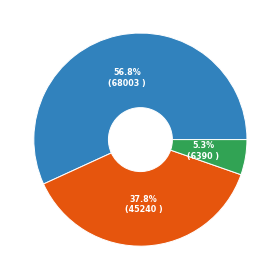

In [11]:
fig, ax = plt.subplots()

size = 0.7
vals = [len(consensus_stage_1_questions), len(consensus_after_validate), len(no_consensus_after_validate)]

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(vals, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'),
       autopct=lambda pct: func(pct, vals),
                textprops=dict(color="w"))
# ax.legend(wedges, [f"{_}" for _ in range(1, 4)],
#           title="Number of Answers",
#           loc="center left",
#           bbox_to_anchor=(-0.3, 0, 0, 1))

plt.setp(autotexts, size=8, weight="bold")
plt.tight_layout()
# ax.set(aspect="equal", title='Number of different answers')
plt.savefig('newsqa_analysis/newsqa_number_of_items_with_answers.pdf', dpi=600, bbox_inches = 'tight', pad_inches=0)

In [12]:
def print_answers(item):
    print(item['q'])
    print(len(item['text'].split()))
    print('----sourcer------')
    for ans in item['answers']:
        print(ans)
        if 's' in ans['sourcerAnswers'][0]:
            for _ans in ans['sourcerAnswers']:
                print(item['text'][_ans['s']:_ans['e']])
    if 'validatedAnswers' not in item:
        return        
    print('----validate------')
    for ans in item['validatedAnswers']:
        print(ans)
        if 's' in ans:
            print(item['text'][ans['s']:ans['e']])


In [13]:
print_answers(consensus_after_validate[300])


According to Joan Rivers who was "totally devoted"?
635
----sourcer------
{'sourcerAnswers': [{'s': 1623, 'e': 1639}, {'s': 1642, 'e': 1654}]}
totally devoted 
each other. 
{'sourcerAnswers': [{'s': 1769, 'e': 1809}, {'s': 353, 'e': 364}, {'s': 390, 'e': 402}]}
He doted on what she said, she doted on 
Richardson 
Liam Neeson 
{'sourcerAnswers': [{'s': 1642, 'e': 1654}]}
each other. 
----validate------
{'count': 2, 'noAnswer': True}


In [14]:
unswerable_only_after_validation = [_  for _ in consensus_after_validate if 's' not in _['consensus']]

In [15]:
len(unswerable_only_after_validation)

6012

In [16]:
6012/len(questions)

0.050253692543027424

In [17]:
answer_after_validation = [_  for _ in consensus_after_validate if 's' in _['consensus']]

In [18]:
print_answers(unswerable_only_after_validation[300])


Is the rating similar to the 100 day mark?
369
----sourcer------
{'sourcerAnswers': [{'noAnswer': True}]}
{'sourcerAnswers': [{'s': 1953, 'e': 1961}, {'s': 1968, 'e': 2004}, {'s': 2007, 'e': 2030}]}
current 
certainly does not indicate that he 
out of the woods yet."

{'sourcerAnswers': [{'s': 620, 'e': 646}, {'s': 652, 'e': 698}]}
Obama getting fairly high 
on most of the issues he has handled so far," 
----validate------
{'count': 2, 'noAnswer': True}


In [19]:
print_answers(answer_after_validation[300])


When was the 6.3 magnitude quake reported?
281
----sourcer------
{'sourcerAnswers': [{'s': 137, 'e': 145}]}
Monday, 
{'sourcerAnswers': [{'s': 1099, 'e': 1114}]}
1 p.m. Monday.

{'sourcerAnswers': [{'s': 1177, 'e': 1182}]}
2:20 
----validate------
{'count': 2, 's': 1099, 'e': 1114}
1 p.m. Monday.



In [39]:
stage1_badquestions = [_ for _ in consensus_stage_1_questions if 'isQuestionBad' in _ and _['isQuestionBad'] >= 0.5]
stage1_good_questions_no_answer = [_ for _ in consensus_stage_1_questions if 'noAnswer' in _['consensus'] and _['consensus']['noAnswer']  and not ('isQuestionBad' in _ and _['isQuestionBad'] != 0)]

In [40]:
print(f"# bad questions: {len(stage1_badquestions)}; # good questions with no answer: {len(stage1_good_questions_no_answer)}")

# bad questions: 11377; # good questions with no answer: 10530


In [43]:
stage1_good_questions_no_answer[500]

{'q': 'What could be more militant than a commando?',
 'consensus': {'noAnswer': True},
 'answers': [{'sourcerAnswers': [{'noAnswer': True}]},
  {'sourcerAnswers': [{'noAnswer': True}]}],
 'isAnswerAbsent': 1.0,
 'text': '(CNN)  -- One Australian soldier, three civilians and Taliban militants were killed early Friday during heavy fighting in southern Afghanistan, according to information from Australian and NATO officials.\n\nFour Australian troops have now died in the conflict in Afghanistan.\n\nThe incident occurred in Tarin Kowt in Uruzgan province, where Taliban militants killed an Australian commando, the Australian Defence Ministry said.\n\nThe 26-year-old commando -- Pvt. Luke Worsley of Sydney -- served with the Special Operations Task Group. This is the fourth Australian troop to die in the Afghan conflict.\n\n"The action in which Private Worsley died only concluded in the last few hours and was characterized by heavy, close quarter fighting. The SOTG was conducting an operati

In [1]:
import json
import re
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
import tqdm
from nltk import wordpunct_tokenize
import torch

In [2]:
newsqa = json.load(open("data/newsqa/combined-newsqa-data-v1.json"))['data']
    
dataset = {'train':[], 'dev':[], 'test':[]}

for item in newsqa:
    dataset[item['type']].append(item)

In [3]:
len(wordpunct_tokenize(dataset['test'][0]['text']))

662

In [4]:
context_word_cnt = {}
cons_answer_num_cnt = {}
ncons_answer_num_cnt = {}
answer_word_cnt = {}

for dataset_subset in dataset.keys():
    context_word_cnt[dataset_subset] = []
    ncons_answer_num_cnt[dataset_subset] = []
    cons_answer_num_cnt[dataset_subset] = []
    answer_word_cnt[dataset_subset] = []

    for i, item in enumerate(tqdm.tqdm(dataset[dataset_subset])):
        src = item['text']
        storyid = item['storyId']
        tokenized_src = wordpunct_tokenize(src)
        context_word_cnt[dataset_subset].append(len(tokenized_src))
        for j, question in enumerate(item['questions']):
            q_ans = []
            if 'validatedAnswers' in question and len(question['validatedAnswers']) <= 2:                  
                consensus = question['consensus']
                consensus_ans_text = None
                all_ans_text = []
                ans_idx = []
                if 's' not in consensus or 'e' not in consensus:
                    no_ans = True
                else:
                    consensus_ans_text = src[consensus['s']:consensus['e']].strip()
                # aggregation after validation.            
                for answer in question['answers']:
                    for ans in answer['sourcerAnswers']:
                        q_ans.append(ans)
                        if 's' in ans and 'e' in ans:
                            ans_t = wordpunct_tokenize(src[ans['s']:ans['e']])
                            answer_word_cnt[dataset_subset].append(len(ans_t))
                ncons_answer_num_cnt[dataset_subset].append(len(q_ans))
            elif 'validatedAnswers' not in question:
                for answer in question['answers']:
                    for ans in answer['sourcerAnswers']:
                        q_ans.append(ans)
                        if 's' in ans and 'e' in ans:
                            ans_t = wordpunct_tokenize(src[ans['s']:ans['e']])
                            answer_word_cnt[dataset_subset].append(len(ans_t))
                cons_answer_num_cnt[dataset_subset].append(len(q_ans))
    

                


100%|██████████| 637/637 [00:00<00:00, 3386.01it/s]


In [5]:
rotation = 0
xtick_size=16
xlabel_size=16
ylabel_size=16
legend_size=15

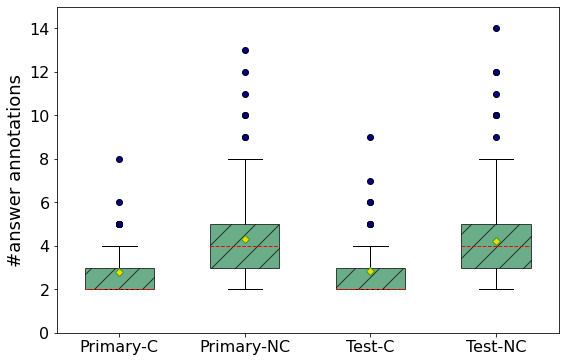

In [9]:

labels = ['Primary-C', 'Primary-NC', 'Test-C', 'Test-NC']
widths = [0.55] * len(labels)
colors = ['seagreen'] * len(labels)
hatch_patterns = ['/'] * len(labels)
fig, axs = plt.subplots(figsize=(9, 6))
bplot = axs.boxplot(
    [cons_answer_num_cnt['train'], ncons_answer_num_cnt['train'], cons_answer_num_cnt['test'], ncons_answer_num_cnt['test']],
    patch_artist=True,
    labels=labels,
    boxprops={'alpha':0.7},
    flierprops={'marker':'o', 'markerfacecolor':'darkblue', 'color':'black'},
    meanprops={'marker':'D', 'markerfacecolor':'gold'},
    medianprops={'linestyle':'--', 'color':'red'},
    showmeans=True,
    widths=widths,
    showfliers=True #False
)
for patch, color, hatch in zip(bplot['boxes'], colors, hatch_patterns):
    patch.set_facecolor(color)
    patch.set_hatch(hatch)
axs.set_ylim(0, 15)
# control fliers
fliers = bplot['fliers']
for fly in fliers:
    fdata = fly.get_data()    
    fly.set_data([fdata[0][0]],fdata[1][:8])

plt.xticks(rotation=rotation, fontsize=xtick_size)
plt.yticks(fontsize=xtick_size)
# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('#answer annotations', fontsize=18)
plt.savefig('number_candidates.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


In [6]:
dataset_subset = 'test' #  'train' # 
model_name = "bert-base-uncased" #   'facebook/bart-base' # "bert-large-uncased" # "roberta-base" # 
device_no=4
qa_device = 5
model_name_in_path = model_name.replace('/', '-')
all_question_candidate_answers_with_null_candidate = torch.load(f"{dataset_subset}_all_question_candidate_answers_qa_no_noanswer_add_null_{model_name_in_path}.pt")  


In [7]:
answer_correct_ness = [float(_[1])  for d in all_question_candidate_answers_with_null_candidate for _ in d[3]]
gt_answer_correct_ness = [float(_[1]) for d in all_question_candidate_answers_with_null_candidate for i, _ in enumerate(d[3]) if i in d[4]]
wrong_answer_correct_ness = [float(_[1]) for d in all_question_candidate_answers_with_null_candidate for i, _ in enumerate(d[3]) if i not in d[4]]

In [8]:
answer_confidence = [float(_) for d in all_question_candidate_answers_with_null_candidate for _ in d[-3]]
gt_answer_confidence = [float(_) for d in all_question_candidate_answers_with_null_candidate for i, _ in enumerate(d[-3]) if i in d[4]]
wrong_answer_confidence = [float(_) for d in all_question_candidate_answers_with_null_candidate for i, _ in enumerate(d[-3]) if i not in d[4]]

In [9]:
from scipy.stats import spearmanr
corr, _ = spearmanr(answer_confidence, answer_correct_ness)
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.325


(array([3581.,  447.,  248.,  178.,  176.,  150.,  115.,   90.,  107.,
          82.,   64.,  100.,   94.,   74.,   62.,   58.,   51.,   55.,
          51.,   58.,   77.,   54.,   46.,   53.,   58.,   53.,   58.,
          59.,   62.,   61.,   64.,   60.,   78.,   56.,   57.,   73.,
          57.,  101.,   67.,   95.,   80.,   73.,   54.,   92.,   68.,
         113.,   85.,  114.,  120.,  199.]),
 array([2.52803467e-08, 1.99707219e-02, 3.99414186e-02, 5.99121153e-02,
        7.98828119e-02, 9.98535086e-02, 1.19824205e-01, 1.39794902e-01,
        1.59765599e-01, 1.79736295e-01, 1.99706992e-01, 2.19677689e-01,
        2.39648385e-01, 2.59619082e-01, 2.79589779e-01, 2.99560475e-01,
        3.19531172e-01, 3.39501868e-01, 3.59472565e-01, 3.79443262e-01,
        3.99413958e-01, 4.19384655e-01, 4.39355352e-01, 4.59326048e-01,
        4.79296745e-01, 4.99267442e-01, 5.19238138e-01, 5.39208835e-01,
        5.59179532e-01, 5.79150228e-01, 5.99120925e-01, 6.19091622e-01,
        6.39062318e-01, 

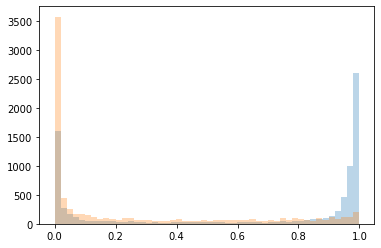

In [88]:
plt.hist(answer_correct_ness, bins=50, alpha=0.3)
plt.hist(answer_confidence, bins=50, alpha=0.3)

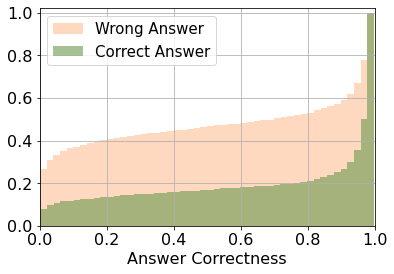

In [16]:
plt.hist(wrong_answer_correct_ness, alpha=0.3, bins=50, density=True, cumulative=True, color='#fe7f2d', label='Wrong Answer')
plt.hist(gt_answer_correct_ness, alpha=0.6, bins=50, density=True, cumulative=True, color='#6a994e', label='Correct Answer')
plt.xlabel('Answer Correctness', fontsize=xlabel_size)
plt.grid()
plt.legend(fontsize=legend_size)
plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=xtick_size)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.savefig('answer_correctness_distribution.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

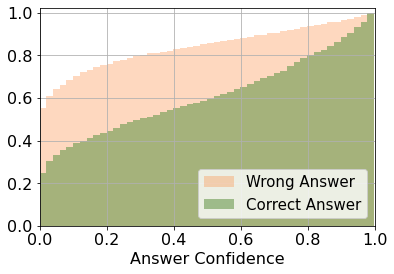

In [20]:

plt.hist(wrong_answer_confidence, alpha=0.3, bins=50, density=True, cumulative=True, color='#fe7f2d', label='Wrong Answer')
plt.hist(gt_answer_confidence, alpha=0.6, bins=50, density=True, cumulative=True, color='#6a994e', label='Correct Answer')
plt.xlabel('Answer Confidence', fontsize=xlabel_size)
plt.grid()
plt.legend(loc=4,fontsize=legend_size)
plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=xtick_size)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.savefig('answer_confidence_distribution.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

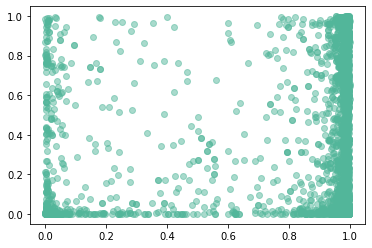

In [103]:
plt.scatter(gt_answer_correct_ness, gt_answer_confidence, alpha=0.5, c='#52b69a')

(array([[200.,  19.,  12.,   6.,  21.,  17.,  13.,  26.,  16.,  22.],
        [ 30.,   1.,   1.,   3.,   0.,   1.,   2.,   5.,   1.,   2.],
        [ 23.,   4.,   2.,   3.,   0.,   4.,   1.,   0.,   2.,   4.],
        [ 12.,   4.,   0.,   1.,   1.,   1.,   0.,   3.,   1.,   2.],
        [ 16.,   5.,   2.,   2.,   1.,   0.,   2.,   2.,   0.,   1.],
        [ 10.,   3.,   8.,   7.,   2.,   0.,   1.,   0.,   0.,   0.],
        [ 17.,   3.,   3.,   1.,   1.,   2.,   0.,   1.,   2.,   3.],
        [ 19.,   3.,   3.,   5.,   1.,   5.,   2.,   2.,   6.,   8.],
        [ 66.,  14.,   4.,   7.,   6.,   6.,   5.,   5.,  10.,  12.],
        [715., 133., 145., 101., 103., 124., 157., 204., 186., 362.]]),
 array([0.00137275, 0.1010504 , 0.20072805, 0.30040571, 0.40008336,
        0.49976101, 0.59943866, 0.69911632, 0.79879397, 0.89847162,
        0.99814928]),
 array([2.37164016e-07, 9.98536993e-02, 1.99707161e-01, 2.99560623e-01,
        3.99414086e-01, 4.99267548e-01, 5.99121010e-01, 6.98974472e-

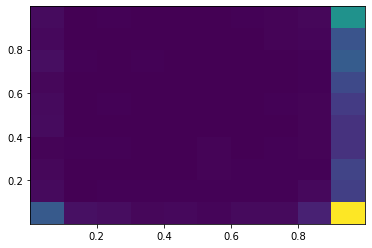

In [115]:
plt.hist2d(gt_answer_correct_ness, gt_answer_confidence)

In [79]:
answer_confidence = [float(_) for _ in answer_confidence]

(array([4630.,  544.,  394.,  273.,  288.,  293.,  315.,  393.,  367.,
         631.]),
 array([2.52803467e-08, 9.98535086e-02, 1.99706992e-01, 2.99560475e-01,
        3.99413958e-01, 4.99267442e-01, 5.99120925e-01, 6.98974408e-01,
        7.98827892e-01, 8.98681375e-01, 9.98534858e-01]),
 <BarContainer object of 10 artists>)

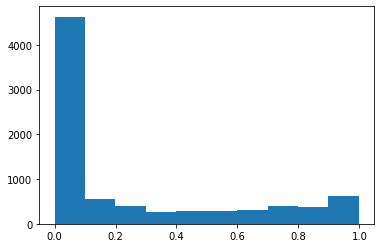

In [80]:
plt.hist(answer_confidence)

In [21]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [22]:
answer_labels = np.array([i in d[4] for d in all_question_candidate_answers_with_null_candidate for i in range(len(d[-3]))])

In [23]:
for _x in np.arange(0.0, 1.0, 0.05):
    answer_scores_q = _x*np.array(answer_confidence) + (1-_x)*np.array(answer_correct_ness)
    fpr_q, tpr_q, _ = roc_curve(answer_labels, answer_scores_q)
    roc_auc_q = auc(fpr_q, tpr_q)
    print(_x, roc_auc_q)

0.0 0.700492991348696
0.05 0.7338948989116774
0.1 0.7385438666478934
0.15000000000000002 0.7414086007206813
0.2 0.7432490887188873
0.25 0.7445759870256514
0.30000000000000004 0.7453586588653702
0.35000000000000003 0.7456791065012541
0.4 0.7459246569984825
0.45 0.7466313235608538
0.5 0.7467194205868702
0.55 0.7470422474617107
0.6000000000000001 0.7473707128069544
0.65 0.7466897941730156
0.7000000000000001 0.7457458555612918
0.75 0.7440193754791071
0.8 0.7420466278687754
0.8500000000000001 0.7386772995833398
0.9 0.7345307097823877
0.9500000000000001 0.7290826436799591


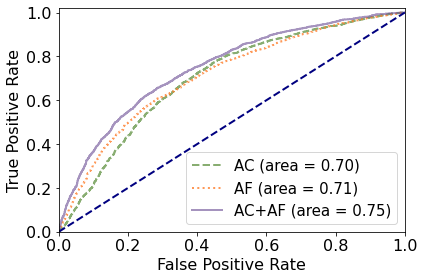

In [25]:
answer_confidence = np.array(answer_confidence)
fpr, tpr, _ = roc_curve(answer_labels, answer_confidence)
roc_auc = auc(fpr, tpr)

answer_correct_ness = np.array(answer_correct_ness)
fpr_c, tpr_c, _ = roc_curve(answer_labels, answer_correct_ness)
roc_auc_c = auc(fpr_c, tpr_c)

answer_scores_s = (answer_confidence+answer_correct_ness)/2
fpr_s, tpr_s, _ = roc_curve(answer_labels, answer_scores_s)
roc_auc_s = auc(fpr_s, tpr_s)

answer_scores_q = np.sqrt(answer_confidence*answer_correct_ness)
fpr_q, tpr_q, _ = roc_curve(answer_labels, answer_scores_q)
roc_auc_q = auc(fpr_q, tpr_q)


# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(answer_labels, answer_confidence)
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr_c,
    tpr_c,
    color="#6a994e",
    lw=lw,
    ls='--',
    alpha=0.8,
    label="AC (area = %0.2f)" % roc_auc_c,
)
plt.plot(
    fpr,
    tpr,
    color="#fe7f2d",
    lw=lw,
    ls=':',
    alpha=0.8,
    label="AF (area = %0.2f)" % roc_auc,
)
plt.plot(
    fpr_s,
    tpr_s,
    color="#6a4c93",
    lw=lw,
    ls='-',
    alpha=0.6,
    label="AC+AF (area = %0.2f)" % roc_auc_s,
)
# plt.plot(
#     fpr_q,
#     tpr_q,
#     color="#fe7f2d",
#     lw=lw,
#     ls=':',
#     alpha=0.8,
#     label="AC*AF (area = %0.2f)" % roc_auc_q,
# )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate", fontsize=xlabel_size)
plt.ylabel("True Positive Rate", fontsize=ylabel_size)
# plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right", fontsize=legend_size)
plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=xtick_size)
plt.tight_layout()
plt.savefig('roc_curve.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()